![](https://cdn20.patchcdn.com/users/22924509/20180417/024653/styles/T800x600/public/processed_images/jag_cz_movie_theater_retro_shutterstock_594132752-1523990060-9711.jpg)
# Description
In this kernel I built an item-based movie recommendation algorithm. The algorithm finds the most similar movies to a given movie, therefore it's not a personal recommender system based on former user behaviour.

Firstly I analyzed the dataset and tried to find to most relevant attributes. For example the "number of rating" attribute is not so relevant in my opinion, because the dataset contains a lot of popular movies without any rating. To find the best solution, I decided to develop an algorithm that can be fine tuned with weights for each used attrributes. 

#### The final list of applied attributes are:
- Average user ratings
- Number of user ratings
- Genres similarity
- User given tags similarity
- Title similarity
- Movie year

After that, I prepared the dataset and computed the relevant measurements.  For better performance of "tag" and "title" words analysis I exluded the most frequent English words from the tags and movie titles.

Finally I created the recommendation algorithm and made some recommendation at the end.  




In [1]:
import numpy as np 
import pandas as pd 
from scipy import spatial

import warnings
warnings.filterwarnings('ignore')

import re
import os
print(os.listdir("../input"))


['README.txt', 'movies.csv', 'links.csv', 'ratings.csv', 'tags.csv']


# Load and check data

In [2]:
ratings = pd.read_csv("../input/ratings.csv")
# links = pd.read_csv("../input/links.csv")
tags = pd.read_csv("../input/tags.csv")
movies = pd.read_csv("../input/movies.csv")

### Ratings

In [3]:
print(ratings.shape)
ratings.head(5)

(1048575, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
pd.options.display.float_format = '{:f}'.format
ratings['rating'].describe()

count   1048575.000000
mean          3.529272
std           1.051919
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

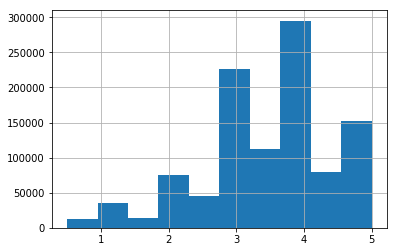

In [45]:
#number of ratings
ratings['rating'].hist()

rating    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

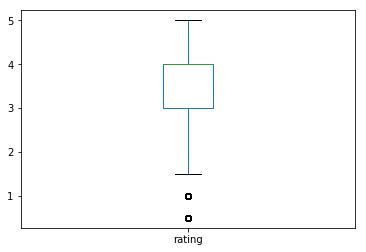

In [6]:
ratings['rating'].plot( kind='box',subplots=True)

### Ratings group by

**Movie ratings aggregated by user:**

In [7]:
userRatingsAggr = ratings.groupby(['userId']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr.head()

userId     rating         
               size     mean
0      1 175.000000 3.742857
1      2  61.000000 4.000000
2      3 187.000000 4.122995
3      4  28.000000 3.571429
4      5  66.000000 4.272727

In [8]:
userRatingsAggr['rating'].describe()

,size,mean
count,7120.000000,7120.000000
mean,147.271770,3.620345
std,220.808148,0.448493
min,20.000000,0.600000
25%,35.000000,3.360000
50%,69.000000,3.650000
75%,161.000000,3.922854
max,2711.000000,5.000000


size       AxesSubplot(0.125,0.125;0.352273x0.755)
mean    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

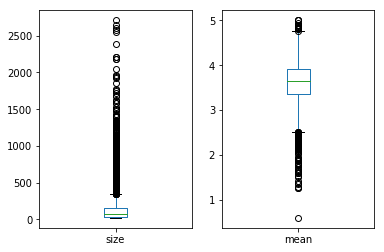

In [9]:
userRatingsAggr['rating'].plot(kind='box', subplots=True)

**Movie ratings aggregated by movie:**

In [10]:
movieRatingsAggr = ratings.groupby(['movieId']).agg({'rating': [np.size, np.mean]})
movieRatingsAggr.reset_index(inplace=True)
movieRatingsAggr.head()

movieId      rating         
                 size     mean
0       1 2569.000000 3.959323
1       2 1155.000000 3.268398
2       3  685.000000 3.186861
3       4  138.000000 3.000000
4       5  657.000000 3.143836

In [11]:
movieRatingsAggr['rating'].describe()

,size,mean
count,14026.000000,14026.000000
mean,74.759375,3.214934
std,218.188441,0.790743
min,1.000000,0.500000
25%,2.000000,2.833333
50%,9.000000,3.363636
75%,43.000000,3.750000
max,3498.000000,5.000000


size       AxesSubplot(0.125,0.125;0.352273x0.755)
mean    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

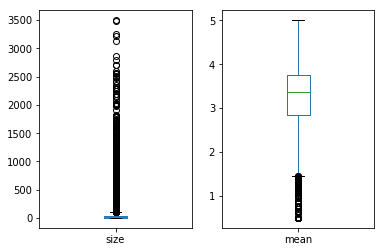

In [12]:
movieRatingsAggr['rating'].plot(kind='box', subplots=True)

### Tags

In [13]:
print(tags.shape)
tags.head(5)

(465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


### Movies (master data)

In [14]:
print(movies.shape)
movies.head(5)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Join movie rating data

In [15]:
movies = movies.merge(movieRatingsAggr, left_on='movieId', right_on='movieId', how='left')  # ['rating']
movies.columns = ['movieId', 'title', 'genres', 'rating_count', 'rating_avg']

In [16]:
movies.head(5)

,movieId,title,genres,rating_count,rating_avg
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836


### Get movie years from title

In [18]:
def getYear(title):
    result = re.search(r'\(\d{4}\)', title)
    if result:
        found = result.group(0).strip('(').strip(')')
    else: 
        found = 0
    return int(found)
    
movies['year'] = movies.apply(lambda x: getYear(x['title']), axis=1)
movies.head(10)

,movieId,title,genres,rating_count,rating_avg,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000,1995
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836,1995
5,6,Heat (1995),Action|Crime|Thriller,1260.000000,3.836508,1995
6,7,Sabrina (1995),Comedy|Romance,700.000000,3.381429,1995
7,8,Tom and Huck (1995),Adventure|Children,78.000000,3.352564,1995
8,9,Sudden Death (1995),Action,202.000000,3.017327,1995
9,10,GoldenEye (1995),Action|Adventure|Thriller,1548.000000,3.427003,1995


### Create genres matrix - one hot encoding
At this step I create a "genresMatrix" field where every value is a list of binary values (19 elements in every list, for the 19 possible genres).  For example a movie with genres "Action", "Adventure" and "Children" will look like: [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] . This transformation called as "one hot encoding".

This matrix will be very useful to define the similarities between two "genres" sets. For this purpose I'm going to compute the Cosine distance between the given arrays. More info: [SciPy spatial.distance.cosine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html)

In [19]:
genresList = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
  "War",
  "Western",
  "(no genres listed)"
]

def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
    
movies['genresMatrix'] = movies.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

movies.head(5)

,movieId,title,genres,rating_count,rating_avg,year,genresMatrix
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Set rating categories
Based on the number of user ratings per movie, I have defined 7 rating groups.

**Check the distribution of ratings per movie**

In [20]:
movieRatingsAggr['rating'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99])

,size,mean
count,14026.000000,14026.000000
mean,74.759375,3.214934
std,218.188441,0.790743
min,1.000000,0.500000
10%,1.000000,2.166667
20%,2.000000,2.666667
30%,3.000000,3.000000
40%,5.000000,3.166667
50%,9.000000,3.363636
60%,16.000000,3.500000


**The desired rating number groups will be:**
* 0 - not rated movie
* 1 - count of ratings between 1 - 10
* 2 - count of ratings between 11 - 30
* 3 - count of ratings between 31 - 100
* 4 - count of ratings between 101 - 300
* 5 - count of ratings between 301 - 1000
* 6 - count of ratings between 1001 - 

In [22]:
def setRatingGroup(numberOfRatings):
    # if (numberOfRatings is None): return 0
    if (1 <= numberOfRatings <= 10): return 1
    elif (11 <= numberOfRatings <= 30): return 2
    elif (31 <= numberOfRatings <= 100): return 3
    elif (101 <= numberOfRatings <= 300): return 4
    elif (301 <= numberOfRatings <= 1000): return 5
    elif (1001 <= numberOfRatings): return 6
    else: return 0

movies['ratingGroup'] = movies.apply(lambda x: setRatingGroup(x['rating_count']), axis=1)
movies.fillna(0, inplace=True)  # Replace NaN values to zero
movies.head(10)

,movieId,title,genres,rating_count,rating_avg,year,genresMatrix,ratingGroup
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2569.000000,3.959323,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6
1,2,Jumanji (1995),Adventure|Children|Fantasy,1155.000000,3.268398,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6
2,3,Grumpier Old Men (1995),Comedy|Romance,685.000000,3.186861,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,138.000000,3.000000,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",4
4,5,Father of the Bride Part II (1995),Comedy,657.000000,3.143836,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
5,6,Heat (1995),Action|Crime|Thriller,1260.000000,3.836508,1995,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
6,7,Sabrina (1995),Comedy|Romance,700.000000,3.381429,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5
7,8,Tom and Huck (1995),Adventure|Children,78.000000,3.352564,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
8,9,Sudden Death (1995),Action,202.000000,3.017327,1995,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
9,10,GoldenEye (1995),Action|Adventure|Thriller,1548.000000,3.427003,1995,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### Tags 
Iterate through all the user given tags, split the tags into words, filter the defined stop words (frequent English words) and put the results into a dictionary that indexed by movieId.

In [24]:
stopWords = ['a', 'about', 'above', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 
        'alone', 'along', 'already', 'also','although','always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 
        'another', 'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 
        'because','become','becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 
        'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 
        'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven','else', 
        'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 
        'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 
        'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 
        'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 
        'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 
        'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 
        'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please', 
        'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 
        'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 
        'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 
        'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 
        'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 
        'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 
        'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 
        'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'the']

tagsDict = {}

for index, x in tags.iterrows():
    wordlist = str(x['tag']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stopWords:
            if movieId in tagsDict:
                # if y not in tagsDict[movieId]:  # Switched off (we will get a non unique list)
                    tagsDict[movieId].append(y)
            else:
                tagsDict[movieId] = [y]

tags.apply(lambda x: str(x['tag']).split(' '), axis=1)
print(tagsDict[6])

['realistic', 'action', 'al', 'pacino', 'michael', 'mann', 'robert', 'niro', 'al', 'pacino', 'michael', 'mann', 'natalie', 'portman', 'robert', 'niro', 'val', 'kilmer', 'ending', 'lame', 'al', 'pacino', 'bank', 'robbery', 'crime', 'dialogue', 'gunfight', 'long', 'los', 'angeles', 'police', 'robert', 'niro', 'tense', 'val', 'kilmer', 'atmospheric', 'bleak', 'slick', 'somber', 'tense', 'visceral', 'witty', 'overrated', 'crime', 'al', 'pacino', 'atmospheric', 'robert', 'niro', 'al', 'pacino', 'atmospheric', 'crime', 'great', 'acting', 'philosophy', 'professionals', 'robert', 'niro', 'suspense', 'tense', 'action', 'al', 'pacino', 'robert', 'niro', 'suspense', 'bleak', 'dialogue', 'long', 'overrated', 'long', 'atmospheric', 'philosophy', 'slow', 'paced', 'tense', 'need', 'michael', 'mann', 'al', 'pacino', 'michael', 'mann', 'robert', 'niro', 'great', 'acting', 'cliched', 'dumbed', 'hollywoodization', 'lame', 'al', 'pacino', 'bank', 'heist', 'dialogue', 'great', 'acting', 'philosophy', 'robe

### Words in movie title
The same as the previous "tags" processing, but for the words in movie title.

In [25]:
titleWordsDict = {}

for index, x in movies.iterrows():
    wordlist = str(x['title']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stopWords:
            if movieId in titleWordsDict:
                    titleWordsDict[movieId].append(y)
            else:
                titleWordsDict[movieId] = [y]

# Movie recommendation algorithm

The algorithm gets a "movieId" as input parameter and computes the similarity for every other movie in the dataset. To fine-tuning this process, we can set up weights for the 6 defined similarity attributes at the beginning of the code. At the end we just ordering the result set (the most similar movies will be at the beginning). 

In [26]:
# Parameter weights
genresSimilarityWeight = 0.8
tagsSimilarityWeight = 2
titleSimilarityWeight = 1
ratingAvgWeight = 0.2
ratingGroupWeight = 0.005
yearDistanceWeight = 0.1

def tagsSimilarity(basisMovieID, checkedMovieID, checkType):    
    # The higher value is the more similar (from 0 to 1) 
    if checkType == 'tag':
        dictToCheck = tagsDict
    else:
        dictToCheck = titleWordsDict
        
    counter = 0
    if basisMovieID in dictToCheck: 
        basisTags = dictToCheck[basisMovieID]
        countAllTags = len(basisTags)
        basisTagsDict = {}
        for x in basisTags:
            if x in basisTagsDict:
                basisTagsDict[x] += 1
            else:
                basisTagsDict[x] = 1   
        
        for x in basisTagsDict:
            basisTagsDict[x] = basisTagsDict[x] / countAllTags
    else: return 0
    
    if checkedMovieID in dictToCheck: 
        checkedTags = dictToCheck[checkedMovieID]
        checkedTags = set(checkedTags) # Make the list unique
        checkedTags = list(checkedTags)
        
    else: return 0
    
    for x in basisTagsDict:
        if x in checkedTags: counter += basisTagsDict[x]
    return counter
    
def checkSimilarity(movieId):
    # print("SIMILAR MOVIES TO:")
    # print (movies[movies['movieId'] == movieId][['title', 'rating_count', 'rating_avg']])
    basisGenres = np.array(list(movies[movies['movieId'] == movieId]['genresMatrix']))
    basisYear = int(movies[movies['movieId'] == movieId]['year'])
    basisRatingAvg = movies[movies['movieId'] == movieId]['rating_avg']
    basisRatingGroup = movies[movies['movieId'] == movieId]['ratingGroup']
    
    moviesWithSim = movies
    moviesWithSim['similarity'] = moviesWithSim.apply(lambda x: 
                                                      spatial.distance.cosine(x['genresMatrix'], basisGenres) * genresSimilarityWeight + 
                                                      - tagsSimilarity(movieId, x['movieId'], 'tag') * tagsSimilarityWeight +
                                                      - tagsSimilarity(movieId, x['movieId'], 'title') * titleSimilarityWeight +
                                                      abs(basisRatingAvg - x['rating_avg']) * ratingAvgWeight +
                                                      abs(basisRatingGroup - x['ratingGroup']) * ratingGroupWeight + 
                                                      abs(basisYear - x['year'])/100 * yearDistanceWeight
                                                     , axis=1)
    
    moviesWithSim = moviesWithSim.loc[(moviesWithSim.movieId != movieId)]
    return moviesWithSim[['movieId', 'title', 'genres', 'rating_count', 'rating_avg', 'similarity']].sort_values('similarity')


In [32]:
currentMovie = movies.loc[(movies.movieId == 3793)]
currentMovie.head(1)

,movieId,title,genres,rating_count,rating_avg,year,genresMatrix,ratingGroup
3702,3793,X-Men (2000),Action|Adventure|Sci-Fi,1422.000000,3.602672,2000,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6


# Movie recommendations

<img style="float: left;" src="https://movieposters2.com/images/1125336-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">X-men</span>

In [33]:
# X-men
similarityResult  = checkSimilarity(3793)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
6234,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,847.000000,3.656434,-2.013412
13677,68319,X-Men Origins: Wolverine (2009),Action|Sci-Fi|Thriller,141.000000,3.241135,-1.153735
7953,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,858.000000,3.552448,-1.147231
11020,45499,X-Men: The Last Stand (2006),Action|Sci-Fi|Thriller,305.000000,3.355738,-1.054679
5252,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller,1256.000000,3.547771,-1.041433


<img style="float: left;" src="https://movieposters2.com/images/744898-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Lock, Stock & Two Smoking Barrels</span>

In [34]:
# Lock, Stock & Two Smoking Barrels
similarityResult  = checkSimilarity(2542)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
3917,4011,Snatch (2000),Comedy|Crime|Thriller,899.000000,4.064516,-1.501847
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,3498.000000,4.153516,-1.060707
1672,1732,"Big Lebowski, The (1998)",Comedy|Crime,1102.000000,3.941470,-0.826102
1067,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,1414.000000,4.062942,-0.726495
12412,57669,In Bruges (2008),Comedy|Crime|Drama|Thriller,242.000000,3.894628,-0.717858


<img style="float: left;" src="https://movieposters2.com/images/1328176-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Casino</span>

In [35]:
# Casino
similarityResult  = checkSimilarity(16)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
1187,1213,Goodfellas (1990),Crime|Drama,1373.000000,4.192280,-1.284371
843,858,"Godfather, The (1972)",Crime|Drama,2137.000000,4.388161,-0.754592
11362,48516,"Departed, The (2006)",Crime|Drama|Thriller,712.000000,4.068820,-0.729753
7633,8042,Mean Streets (1973),Crime|Drama,75.000000,3.793333,-0.723977
1202,1228,Raging Bull (1980),Drama,491.000000,4.022403,-0.722867


<img style="float: left;" src="https://movieposters2.com/images/660783-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Star Wars: Episode IV - A new hope</span>

In [36]:
# Star Wars: Episode IV - A New Hope
similarityResult  = checkSimilarity(260)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
1171,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,2418.000000,4.163358,-2.018229
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,2480.000000,3.992339,-2.002855
10117,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,652.000000,3.464724,-1.316176
2543,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1583.000000,3.083702,-1.272802
5281,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,892.000000,3.117713,-1.256491


<img style="float: left;" src="https://movieposters2.com/images/750888-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Iron Man</span>

In [37]:
# Iron Man
similarityResult  = checkSimilarity(59315)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
15203,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,224.000000,3.582589,-1.690904
20906,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,91.000000,3.675824,-1.521686
17874,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,249.000000,3.947791,-1.225747
12742,60040,"Incredible Hulk, The (2008)",Action|Sci-Fi,131.000000,3.339695,-1.076318
12409,57640,Hellboy II: The Golden Army (2008),Action|Adventure|Fantasy|Sci-Fi,116.000000,3.366379,-0.620550


<img style="float: left;" src="https://images-na.ssl-images-amazon.com/images/I/91BDDsP0clL._RI_SX200_.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">The Good, the Bad and the Ugly</span>

In [38]:
# The Good, the Bad and the Ugly
similarityResult  = checkSimilarity(1201)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
1183,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,244.000000,4.098361,-1.126314
2865,2951,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western,377.000000,3.957560,-0.951320
3590,3681,For a Few Dollars More (Per qualche dollaro in...,Action|Drama|Thriller|Western,258.000000,3.951550,-0.800084
3418,3508,"Outlaw Josey Wales, The (1976)",Action|Adventure|Drama|Thriller|Western,185.000000,3.886486,-0.460397
4232,4327,"Magnificent Seven, The (1960)",Adventure|Western,218.000000,3.961009,-0.331689


<img style="float: left;" src="https://movieposters2.com/images/641096-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Mega Shark vs. Giant Octopus</span>

In [39]:
# Mega Shark vs. Giant Octopus
similarityResult  = checkSimilarity(73829)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
18301,91490,Sharktopus (2010),Action|Horror|Sci-Fi,1.000000,0.500000,-0.416086
18703,93139,Mega Shark vs. Crocosaurus (2010),Action|Adventure|Horror,1.000000,1.000000,-0.349419
6505,6615,Freddy vs. Jason (2003),Action|Horror|Thriller,77.000000,2.259740,-0.310249
2636,2722,Deep Blue Sea (1999),Action|Horror|Sci-Fi|Thriller,361.000000,2.642659,-0.298820
4128,4222,C.H.U.D. (1984),Horror,11.000000,2.136364,-0.177857


<img style="float: left;" src="https://movieposters2.com/images/637194-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">King Kong Escapes (Kingu Kongu no gyakushû)</span>

In [40]:
# King Kong Escapes (Kingu Kongu no gyakushû)
similarityResult  = checkSimilarity(92518)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
17339,87433,"Ghidorah, the Three-Headed Monster (San daikai...",Action|Adventure|Fantasy|Sci-Fi,0.000000,0.000000,-0.441544
9932,32560,Invasion of Astro-Monster (Godzilla vs. Monste...,Action|Adventure|Sci-Fi,0.000000,0.000000,-0.342828
11900,53375,Godzilla vs. King Ghidorah (Gojira vs. Kingu G...,Action|Sci-Fi,0.000000,0.000000,-0.316882
2280,2365,King Kong vs. Godzilla (Kingukongu tai Gojira)...,Action|Sci-Fi,44.000000,2.806818,-0.247203
9826,32076,Godzilla vs. The Sea Monster (Gojira-Ebira-Mos...,Action|Adventure|Fantasy|Sci-Fi,7.000000,1.785714,-0.219333


<img style="float: left;" src="https://movieposters2.com/images/641904-b.jpg" width="280" height="400"> 
<span style="font-size:200%;margin:20px;">Armageddon</span>

In [41]:
# Armageddon
similarityResult  = checkSimilarity(1917)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
1792,1876,Deep Impact (1998),Drama|Sci-Fi|Thriller,645.000000,2.949612,-0.772302
2249,2334,"Siege, The (1998)",Action|Thriller,146.000000,3.273973,-0.527885
2308,2393,Star Trek: Insurrection (1998),Action|Drama|Romance|Sci-Fi,482.000000,3.236515,-0.512835
1750,1831,Lost in Space (1998),Action|Adventure|Sci-Fi,382.000000,2.668848,-0.505924
1752,1833,Mercury Rising (1998),Action|Drama|Thriller,119.000000,3.025210,-0.473832


<img style="float: left;" src="https://movieposters2.com/images/735848-b.jpg" width="280" height="400">
<span style="font-size:200%;margin:20px;">Groundhog Day</span>

In [42]:
# Groundhog Day
similarityResult  = checkSimilarity(1265)
similarityResult.head(5)




,movieId,title,genres,rating_count,rating_avg,similarity
17190,86882,Midnight in Paris (2011),Comedy|Fantasy|Romance,115.000000,3.804348,-0.563815
1189,1215,Army of Darkness (1993),Action|Adventure|Comedy|Fantasy|Horror,642.000000,3.739097,-0.497061
1242,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,2186.000000,3.919488,-0.479135
436,440,Dave (1993),Comedy|Romance,1033.000000,3.622943,-0.475784
11891,53318,Cashback (2006),Comedy|Drama|Romance,61.000000,3.713115,-0.426514


<img style="float: left;" src="https://movieposters2.com/images/645250-b.jpg" width="280" height="400">
<span style="font-size:200%;margin:20px;">Cars</span>

In [43]:
# Cars
similarityResult  = checkSimilarity(45517)
similarityResult.head(5)

,movieId,title,genres,rating_count,rating_avg,similarity
17425,87876,Cars 2 (2011),Adventure|Animation|Children|Comedy|IMAX,17.000000,3.323529,-0.902803
22893,109420,Mater and the Ghostlight (2006),Animation|Children|Comedy,2.000000,4.000000,-0.703647
11016,45431,Over the Hedge (2006),Adventure|Animation|Children|Comedy,114.000000,3.355263,-0.673029
2270,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,1075.000000,3.582326,-0.598527
4790,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1256.000000,3.865844,-0.561366
